In [1]:
#Imports
import pickle
import numpy as np
import os 
import matplotlib.pyplot as plt


# Load data functions
# Functions from Cifar page
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadLabels(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        return [x.decode('ascii') for x in data[b'label_names']]
    
def intToLabel(a):
    strs = ["" for x in range(len(a))]
    for i in range(len(a)):
        strs[i] = labels[a[i]]
    return strs
    
def batchToObject(batch):
    
    convertToText = np.transpose(np.array(batch[b'labels']))
    for i in range(len(batch[b'labels'])):
        zeroVector = np.zeros((10,1))
        zeroVector[batch[b'labels'][i]] = 1
        batch[b'labels'][i] = np.transpose(zeroVector)[0].astype(int)
    # Create new dictionaries
    batchAsObject =  {
        'images': np.divide(batch[b'data'], 255),
        'label':  np.array(batch[b'labels']),
        'labelText': intToLabel(convertToText)
    }
    return batchAsObject

In [2]:
# Destination to dataset
dataDir = "C:/Users/ottarg/Desktop/KTH_PROGRAM/4-Deep Learning/Assignments/DataSets"

# Load labels
labelDir = dataDir + "/batches.meta"
labels = loadLabels(labelDir)

# Advanced parameters for optimization
TRAIN_ALL_DATA = False

if(TRAIN_ALL_DATA):
    training1 = batchToObject(unpickle(dataDir + "/data_batch_1"))
    training2 = batchToObject(unpickle(dataDir + "/data_batch_2"))
    training3 = batchToObject(unpickle(dataDir + "/data_batch_3"))
    training4 = batchToObject(unpickle(dataDir + "/data_batch_4"))
    training5 = batchToObject(unpickle(dataDir + "/data_batch_5"))
    
    # lenOfBatch
    lb = 10000
    #restForVali
    rV = 200
    #sliceIndex
    sl = lb- rV
    training = {
        'images': np.vstack((training1['images'][0:sl], training2['images'][0:sl], training3['images'][0:sl], training4['images'][0:sl], training5['images'][0:sl])) ,
        'label': np.vstack((training1['label'][0:sl], training2['label'][0:sl], training3['label'][0:sl], training4['label'][0:sl], training5['label'][0:sl])) ,
        'labelText': np.vstack((training1['labelText'][0:sl], training2['labelText'][0:sl], training3['labelText'][0:sl], training4['labelText'][0:sl], training5['labelText'][0:sl])) ,
    }
    validate = {
        'images': np.vstack((training1['images'][sl:lb], training2['images'][sl:lb], training3['images'][sl:lb], training4['images'][sl:lb], training5['images'][sl:lb])) ,
        'label': np.vstack((training1['label'][sl:lb], training2['label'][sl:lb], training3['label'][sl:lb], training4['label'][sl:lb], training5['label'][sl:lb])) ,
        'labelText': np.vstack((training1['labelText'][sl:lb], training2['labelText'][sl:lb], training3['labelText'][sl:lb], training4['labelText'][sl:lb], training5['labelText'][sl:lb])) ,
    }
    
    
else:    
    training = batchToObject(unpickle(dataDir + "/data_batch_1"))
    validate = batchToObject(unpickle(dataDir + "/data_batch_2"))

testing = batchToObject(unpickle(dataDir + "/test_batch"))

# Exercise 1 - batch normalization
train_meanVal = np.mean(np.transpose(training['images']), axis=1)

def calculateBatchNormalize(inputData,meanv):

    nData = np.shape(inputData)[0]
    ones = np.eye(nData,nData)
    
    fir = np.transpose(np.transpose(inputData) - meanv)
    return np.transpose(np.dot(ones, fir))

# You should only compute the mean for the training data and then
# keep a record of this mean and subtract it from the input vectors in the validation and test sets.
training['images'] = calculateBatchNormalize(np.transpose(training['images']), train_meanVal)
validate['images'] = calculateBatchNormalize(np.transpose(validate['images']), train_meanVal)
testing['images']  = calculateBatchNormalize(np.transpose(testing['images']) , train_meanVal)



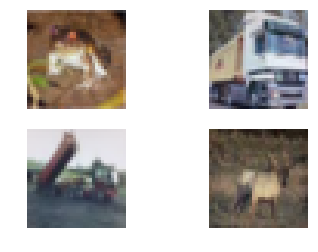

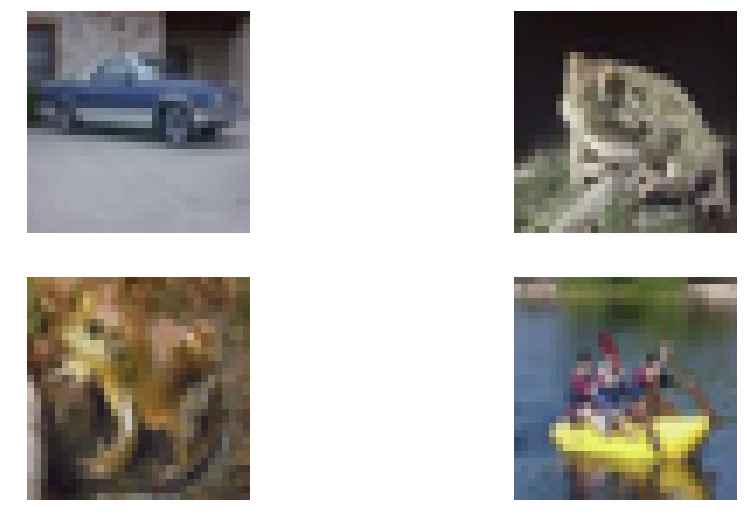

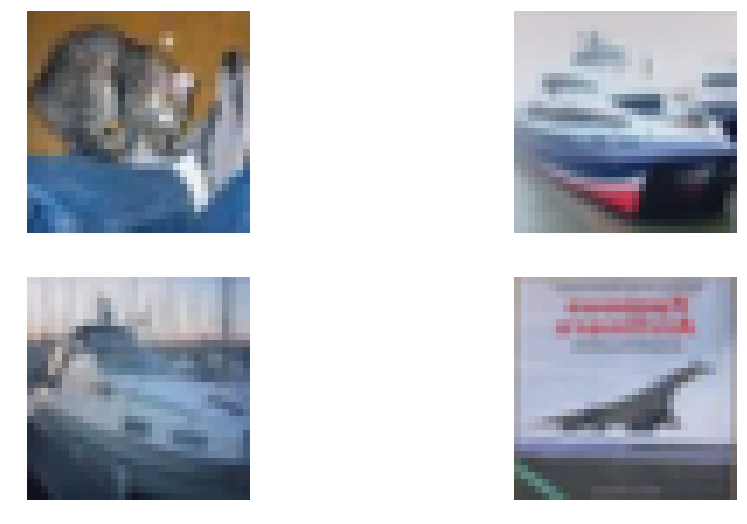

In [3]:
# Draw the edited data
def dispImg(img, label):
    # ‘F’ means to read / write the elements using Fortran-like index order, 
    # with the first index changing fastest, and the last index changing slowest.
    loadImg = np.reshape(img, (32, 32, 3), order='F') 
    rotImg = np.rot90(loadImg, k=3) # change to 3 times?
    plt.rcParams["figure.figsize"] = [16,9]
    plt.imshow(rotImg)
    plt.axis('off')
    plt.title(label)

def plotManyImg(dataset,n,m):
    imgNo = 0
    for i in range(n*m): 
        plt.subplot(n, m, i+1)
        dispImg(dataset['images'][i], dataset['labelText'][i])
    plt.show()

def plotNormalizedSet(normSet,n,m):
    imgNo = 0
    for i in range(n*m): 
        plt.subplot(n, m, i+1)
        dispImg(normSet[i], "")
    plt.show()

def normalize(weightMatrix):
    maxVal = np.max(weightMatrix)
    minVal = np.min(weightMatrix)
    return (weightMatrix - minVal) / (maxVal - minVal)    
    
normTrain = normalize(np.transpose(training['images']))
normValid = normalize(np.transpose(validate['images']))
normTest = normalize(np.transpose(testing['images']))
    
# Plot the batch normalized images
plotNormalizedSet(np.transpose(normTrain)[0:4],2,2)
plotNormalizedSet(np.transpose(normValid)[0:4],2,2)
plotNormalizedSet(np.transpose(normTest)[0:4],2,2)


In [68]:
# Helping functions

# Softmax function
def softmaxForward(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def reluForward(x):
    # TODO: Check this
    #reluVal = max(x,0) # error.any() or .all()?
    # Neat little trick here
    return x * (x > 0)

# Cross entropy
def crossEntropy(X):
    m = len(X)
    logLikelihood = -np.log(X)
    loss = np.sum(logLikelihood) / m
    return loss

# Calculating functions
def evaluateClassifier(inputData, weights, bias, h_weights, h_bias,  h_weights1, h_bias1):
    # Calculate the softmax with dot product of weights and input
    calc1 = calculateLayerForward(inputData, weights, bias)
    relu1 = reluForward(calc1)
    calc2 = calculateLayerForward(relu1, h_weights, h_bias)
    relu2 = reluForward(calc2)
    calc3 = calculateLayerForward(relu2, h_weights1, h_bias1)
    softmax2 = softmaxForward(calc3)
    return softmax2


# Returns the net outcome 
def calculateLayerForward(inputData,weights, bias):
    # Calculate the softmax with dot product of weights and input
    calculateNetwork = np.dot(weights, inputData) + bias
    return calculateNetwork


def computeCost(probab, realLabel, weights, lambdaVal):
    winValue = np.multiply(realLabel, probab)
    sumValue = winValue.sum(axis=0)
    # Calculate cross-entropy loss
    # Add regularization
    regularization = lambdaVal * np.sum(np.power(weights, 2))
    crossEntropyLoss = crossEntropy(sumValue) + regularization
    return  crossEntropyLoss

def computeAccuracy(probab, realLabel):
    # Get the index of the real class
    # Select the winning(max value) index of each array
    predict = np.argmax(probab, axis=0)
    realLabel = np.argmax(realLabel, axis=0)
    # Count how many were actually correctly classified
    percOfCorrectlyClassified = (np.sum(predict == realLabel)) / len(realLabel)
    # Divide by number of elements to get percentage
    return percOfCorrectlyClassified 


In [58]:
# Functions for calculating the gradients

def calculateGradient(inputData, probab, realLabel, weights, bias, lambdaVal):

    #print("SOFTSTART")
    #print(inputData, probab, realLabel, weights, bias, lambdaVal)
    
    weightsGradient = np.zeros((np.shape(weights)[0],np.shape(weights)[1]))
    biasGradient = np.zeros((np.shape(bias)[0],np.shape(bias)[1]))
    
    gradients = []
    
    N = np.shape(realLabel)[1]
    for i in range(N):
        # Evaluate p - already have it
        pVal = probab[:, i]
        # X
        inputX = inputData[:, i]
        # y
        target = realLabel[:,i]
        # Let
        gradVal = pVal - target
        gradients.append(gradVal)
        # Add gradient of l(x; y;W; b) w.r.t. b
        biasGradient += np.reshape(gradVal, np.shape(biasGradient))
        # Add gradient of l(x; y;W; b) w.r.t. W:
        weightsGradient += np.outer(gradVal, inputX)

    # Add regularization
    regularization = 2 * lambdaVal * weights
    # Add the gradient for the regularization term
    weightsGradient = (weightsGradient / N) + regularization
    biasGradient = biasGradient / N
    
    gradientChange = np.dot(gradients, weights)
    return weightsGradient, biasGradient, gradientChange

                       
def calculateGradientRelu(inputData, probab, realLabel, weights, bias, lambdaVal):
    weightsGradient = np.zeros((np.shape(weights)[0],np.shape(weights)[1]))
    biasGradient = np.zeros((np.shape(bias)[0],np.shape(bias)[1]))
    
    gradients = []
    N = np.shape(probab)[1]
    
    # or g = g*Wi # same way back
    gradVal = np.multiply(realLabel, np.transpose(probab) > 0)
        
    for i in range(N):
        inputX = inputData[:, i]
        grad = gradVal[i, :]
        
        gradients.append(grad)
        # Add gradient of l(x; y;W; b) w.r.t. b
        
        biasGradient += np.reshape(grad, np.shape(biasGradient))
        # Add gradient of l(x; y;W; b) w.r.t. W:
        weightsGradient += np.outer(grad, inputX)

    # Add regularization
    regularization = 2 * lambdaVal * weights
    # Add the gradient for the regularization term
    weightsGradient = (weightsGradient / N) + regularization
    biasGradient = biasGradient / N
    
    # NOTE: 
    # The gradients for two layer network is not needed but should be here if the network was stacked using more layers
    gradientChange = np.dot(gradients, weights)
    return weightsGradient, biasGradient, gradientChange


In [44]:
# Here I'm checking if the network can successly do 1 simple epoch
np.random.seed(5)

inputNodes = 32*32*3 # 32*32*rgb
hiddenNodes = 50
outputNodes = 10

#First layer
inputWeights = np.random.normal(0.0, 0.001, (hiddenNodes, inputNodes))
inputBias = np.random.normal(0.0, 0.001, (hiddenNodes, 1))

#Hidden layer
hiddenWeights = np.random.normal(0.0, 0.001, (outputNodes, hiddenNodes))
hiddenBias = np.random.normal(0.0, 0.001, (outputNodes, 1))

eta = 0
lambdaVal = 0.0
n = 100 # First 50 images
inputData = np.transpose(training['images'][0:n])
realLabel = np.transpose(training['label'][0:n])

calc1 = calculateLayerForward(inputData, inputWeights, inputBias)

relu1 = reluForward(calc1)

calc2 = calculateLayerForward(relu1, hiddenWeights, hiddenBias)
softmax2 = softmaxForward(calc2)

probab = evaluateClassifier(inputData, inputWeights, inputBias, hiddenWeights, hiddenBias)

startingCost = computeCost(softmax2, realLabel,  hiddenWeights, lambdaVal)
acc = computeAccuracy(probab, realLabel)
# Forward pass
print('Cost:', startingCost)
print('Acc:', acc)
# Backwards pass, compute gradients
hiddenWeightsGradient, hiddenBiasGradient, hiddenGradChange = calculateGradient(relu1, softmax2, realLabel, hiddenWeights, hiddenBias, lambdaVal)


inputWeightsGradient, inputBiasGradient, inputGradChange = calculateGradientRelu(inputData, calc1, hiddenGradChange, inputWeights, inputBias, lambdaVal)


# Starting cost is around 2.3 ~= ln(1)

Cost: 2.30273930047
Acc: 0.11


In [754]:
# Exercise 2: Compute the gradients for the network parameters for the first 100 items

# Here I will check if the gradients are computed correctly
np.random.seed(5)

inputNodes = 32*32*3 # 32*32*rgb
hiddenNodes = 25
outputNodes = 10

#First layer
inputWeights = np.random.normal(0.0, 0.001, (hiddenNodes, inputNodes))
inputBias = np.random.normal(0.0, 0.001, (hiddenNodes, 1))

#Hidden layer
hiddenWeights = np.random.normal(0.0, 0.001, (outputNodes, hiddenNodes))
hiddenBias = np.random.normal(0.0, 0.001, (outputNodes, 1))

lambdaVal = 0.0
n = 100 # First 100 images
inputData = np.transpose(training['images'][0:n])
realLabel = np.transpose(training['label'][0:n])

# Forward pass
calc1 = calculateLayerForward(inputData, inputWeights, inputBias)
relu1 = reluForward(calc1)
calc2 = calculateLayerForward(relu1, hiddenWeights, hiddenBias)
softmax2 = softmaxForward(calc2)
startingCost = computeCost(softmax2, realLabel, hiddenWeights, lambdaVal)

# Backwards pass, compute gradients
hiddenWeightsGradient, hiddenBiasGradient, hiddenGradChange = calculateGradient(relu1, softmax2, realLabel, hiddenWeights, hiddenBias, lambdaVal)
inputWeightsGradient, inputBiasGradient, _ = calculateGradientRelu(inputData, calc1, hiddenGradChange, inputWeights, inputBias, lambdaVal)

# Changed this function to just simply calculate one weight matrix at a time
def computeGradsNum(realLabel, inputData,
                             weightInput, 
                             totalCostInput):
    # Initialize an empty matrix to contain the gradients
    gradients = np.zeros(np.shape(weightInput))
    h = 1e-5  
    
    for i in range(np.shape(weightInput)[0]):
        for j in range(np.shape(weightInput)[1]):
            weightInput[i, j] += h
            
            # Do the forward pass and get the final cost
            calc1 = calculateLayerForward(inputData, inputWeights, inputBias)
            relu1 = reluForward(calc1)
            calc2 = calculateLayerForward(relu1, hiddenWeights, hiddenBias)
            softmax2 = softmaxForward(calc2)

            totalCost2 = computeCost(softmax2, realLabel, hiddenWeights, lambdaVal)
            
            #final_cost = network.cost(one_hot_targets, inputs)
            gradients[i, j] = (totalCost2 - totalCostInput) / h
            weightInput[i, j] -= h
    return gradients

numWeightGrads = computeGradsNum(realLabel,inputData, inputWeights,  startingCost)
numBiasGrads = computeGradsNum(realLabel,inputData, inputBias,  startingCost)
numHiddenWeightGrads = computeGradsNum(realLabel,inputData, hiddenWeights,  startingCost)
numHiddenBiasGrads = computeGradsNum(realLabel,inputData, hiddenBias,  startingCost)

print("done computing - results")

#Compare them
def compareDifferenation(infoString, weightsGradient, weightsGradientNum):
    minVal = 1e-6 
    
    # Compute the relative error of weights
    ga_gn = np.sum(np.abs(weightsGradient - weightsGradientNum))
    
    ga = np.sum(np.abs(weightsGradient))
    gn = np.sum(np.abs(weightsGradientNum))
    
    maxVal = max(minVal, ga + gn)
    
    weightCheck = ga_gn / maxVal
    print("The relative error of " +infoString+ " is " + str(weightCheck))

compareDifferenation("First layer weights", inputWeightsGradient, numWeightGrads)
compareDifferenation("First layer bias", inputBiasGradient, numBiasGrads)
compareDifferenation("Second layer weights", hiddenWeightsGradient, numHiddenWeightGrads)
compareDifferenation("Second layer bias", hiddenBiasGradient, numHiddenBiasGrads)

done computing - results
The relative error of First layer weights is 9.96426726888e-07
The relative error of First layer bias is 5.12623893905e-05
The relative error of Second layer weights is 5.30763719076e-08
The relative error of Second layer bias is 7.02932340418e-06


In [77]:
# Exercise 3
# Creating the training loop with momentum

def train( weights, bias, h_wheights, h_bias, h_wheights1, h_bias1, trainData, validData, eta, epochs, batchSize, lambdaVal, momentum):
    
    nOfSamples = len(trainData['images'])
    nOfBatch = int(nOfSamples / batchSize)
    
    inputData = np.transpose(trainData['images'])
    realLabel = np.transpose(trainData['label'])
    
    val_inputData = np.transpose(validData['images'])
    val_realLabel = np.transpose(validData['label'])
     
    accuracyTraining = []
    accuracyValidation = []
    costTraining = []
    costValidation = []
    
    # Momentum arrays
    w1_momentum = np.zeros((np.shape(weights)))
    b1_momentum = np.zeros((np.shape(bias)))
    w2_momentum = np.zeros((np.shape(h_wheights)))
    b2_momentum = np.zeros((np.shape(h_bias)))
    w3_momentum = np.zeros((np.shape(h_wheights1)))
    b3_momentum = np.zeros((np.shape(h_bias1)))
    
    for epoch in range(epochs):
        print("Epoch: " + str(epoch))
        for i in range(nOfBatch):
            # Prepare batch
            startOfBatch = i * batchSize
            endOfBatch = (i+1) * batchSize
            batch_inputData = np.transpose(trainData['images'][startOfBatch:endOfBatch])
            batch_realLabel = np.transpose(trainData['label'][startOfBatch:endOfBatch])

            # Update weights
            
            calc1 = calculateLayerForward(batch_inputData, weights, bias)
            relu1 = reluForward(calc1)
            calc2 = calculateLayerForward(relu1, h_wheights, h_bias)
            relu2 = reluForward(calc2)
            calc3 = calculateLayerForward(relu2, h_wheights1, h_bias1)
            softmax3 = softmaxForward(calc3)
            
            hiddenWeightsGradient1, hiddenBiasGradient1, hiddenGradChange1 = calculateGradient(
                relu2, softmax3, batch_realLabel, h_wheights1, h_bias1, lambdaVal)
            
            w3_momentum = momentum * w3_momentum + eta * hiddenWeightsGradient1
            b3_momentum = momentum * b3_momentum + eta * hiddenBiasGradient1
            
            h_bias1 -= b3_momentum
            h_wheights1 -= w3_momentum
            
            hiddenWeightsGradient, hiddenBiasGradient, hiddenGradChange = calculateGradientRelu(
                relu1, relu2, hiddenGradChange1, h_wheights, h_bias, lambdaVal)
            
            w2_momentum = momentum * w2_momentum + eta * hiddenWeightsGradient
            b2_momentum = momentum * b2_momentum + eta * hiddenBiasGradient
            
            h_bias -= b2_momentum
            h_wheights -= w2_momentum
            
            inputWeightsGradient, inputBiasGradient, _ = calculateGradientRelu(
                batch_inputData, relu1, hiddenGradChange, inputWeights, inputBias, lambdaVal)
            
            w1_momentum = momentum * w1_momentum + eta * inputWeightsGradient
            b1_momentum = momentum * b1_momentum + eta * inputBiasGradient
            

            bias -= b1_momentum
            weights -= w1_momentum
            
            
        # DECAY RATE   
        eta *= 0.95 
        
        calc1 = calculateLayerForward(inputData, weights, bias)
        relu1 = reluForward(calc1)
        calc2 = calculateLayerForward(relu1, h_wheights, h_bias)
        relu2 = reluForward(calc2)
        calc3 = calculateLayerForward(relu2, h_wheights1, h_bias1)
        softmax3 = softmaxForward(calc3)
        
        #probab = evaluateClassifier(inputData, weights, bias, h_wheights, hiddenBias,h_wheights1, hiddenBias1)
        #val_probab = evaluateClassifier(val_inputData, weights, bias, h_wheights, hiddenBias,h_wheights1, hiddenBias1)

        totalCost = computeCost(softmax3, realLabel,  h_wheights1, lambdaVal)
        #val_totalCost = computeCost(val_probab, val_realLabel,  hiddenWeights, lambdaVal)
   
        # How many in the training set are correctly classified
        totalAccuracy = computeAccuracy(softmax3, realLabel)

        # How many in the validation set are correctly classified based on the training set
        #val_totalAccuracy = computeAccuracy(val_probab, val_realLabel)
        
        # Add to list
        accuracyTraining.append(totalAccuracy)
        #accuracyValidation.append(val_totalAccuracy)
        
        costTraining.append(totalCost)
        #costValidation.append(val_totalCost)
        
    print("Done")
    return accuracyTraining, accuracyValidation, costTraining, costValidation

In [78]:

import random
np.random.seed(5)

inputNodes = 32*32*3 # 32*32*rgb
hiddenNodes = 50
outputNodes = 10

variance = 0.001
    
#First layer
inputWeights = np.random.normal(0.0, variance, (50, inputNodes))
inputBias = np.random.normal(0.0, variance, (50, 1))

#Hidden layer
hiddenWeights1 = np.random.normal(0.0, variance, (30, 50))
hiddenBias1 = np.random.normal(0.0, variance, (30, 1))

hiddenWeights2 = np.random.normal(0.0, variance, (outputNodes, 30))
hiddenBias2 = np.random.normal(0.0, variance, (outputNodes, 1))

eta = 0.29189273799480775
epoch = 5
batch = 500
lambdaVal = 8.248206928786062e-05
momentum = 0.9

# run the training
accuracyTraining, accuracyValidation, costTraining, costValidation = train(
    inputWeights, 
    inputBias, 
    hiddenWeights1, 
    hiddenBias1, 
    hiddenWeights2, 
    hiddenBias2, 
    training,
    validate, 
    eta, 
    epoch, 
    batch, 
    lambdaVal,
    momentum)

print("Info on network with lambda=" +str(lambdaVal) + " epochs=" + str(epoch) + " batch=" + str(batch) + " eta="+str(eta) )
printInfo(training, validate, testing, inputNodes, inputWeights,inputBias, hiddenWeights, hiddenBias, h2,b2, outputNodes, eta)
#plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
Info on network with lambda=8.248206928786062e-05 epochs=5 batch=500 eta=0.29189273799480775


TypeError: evaluateClassifier() missing 2 required positional arguments: 'h_weights1' and 'h_bias1'

In [80]:
print(costTraining)
      
      #, accuracyValidation, costTraining, costValidation
     

[2.3023818436880457, 2.3022503042917921, 2.3022579336627831, 2.3022405306425004, 2.3022367109186752]


Done
Network lambda=1e-06 epochs=5 batch=500 eta=0.005 momentum=0.5
Info on Training data: Accuracy: 10.32% and Cost: 2.3
Info on Validation data: Accuracy: 10.1% and Cost: 2.3
Info on Testing data: Accuracy: 10.0% and Cost: 2.3


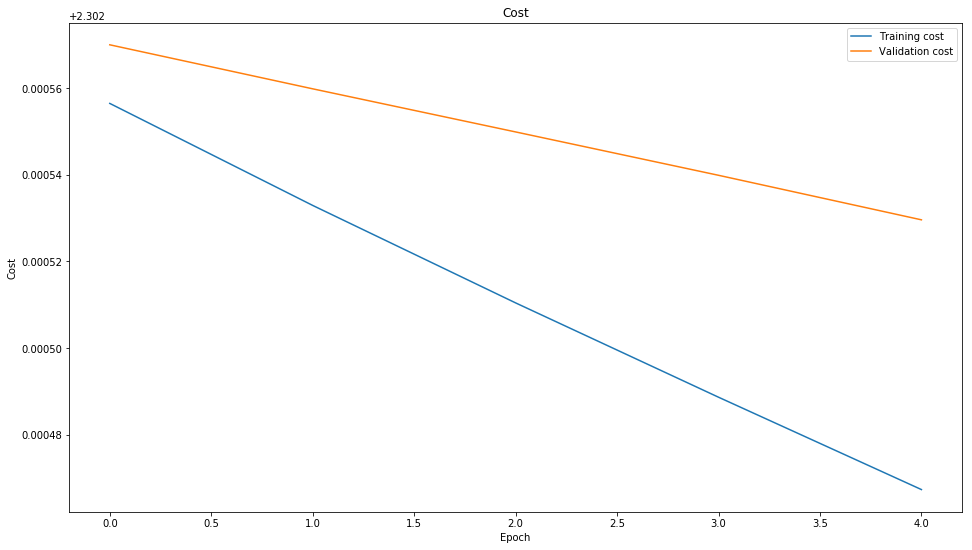

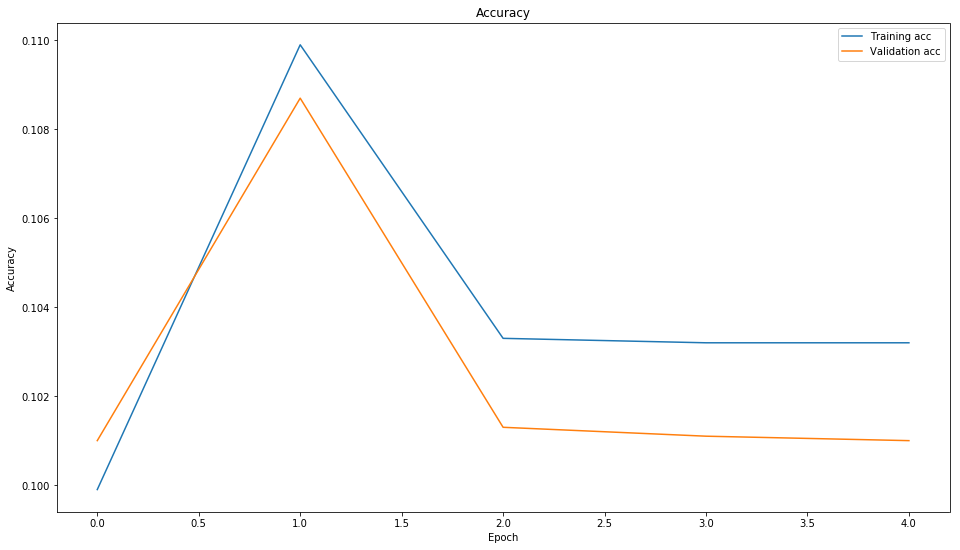

Done
Network lambda=1e-06 epochs=5 batch=500 eta=0.005 momentum=0.9
Info on Training data: Accuracy: 15.55% and Cost: 2.3
Info on Validation data: Accuracy: 14.74% and Cost: 2.3
Info on Testing data: Accuracy: 14.93% and Cost: 2.3


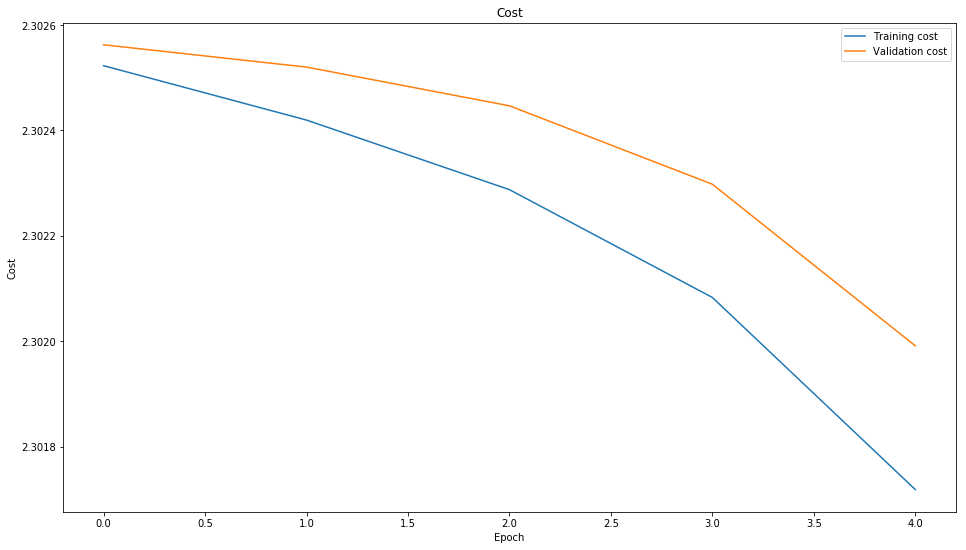

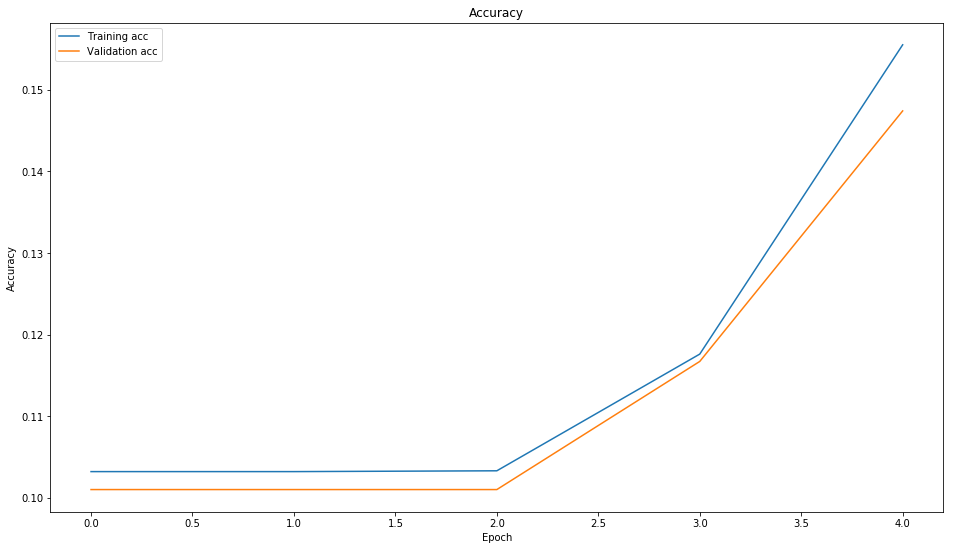

Done
Network lambda=1e-06 epochs=5 batch=500 eta=0.005 momentum=0.99
Info on Training data: Accuracy: 18.32% and Cost: 2.27
Info on Validation data: Accuracy: 17.44% and Cost: 2.27
Info on Testing data: Accuracy: 18.11% and Cost: 2.27


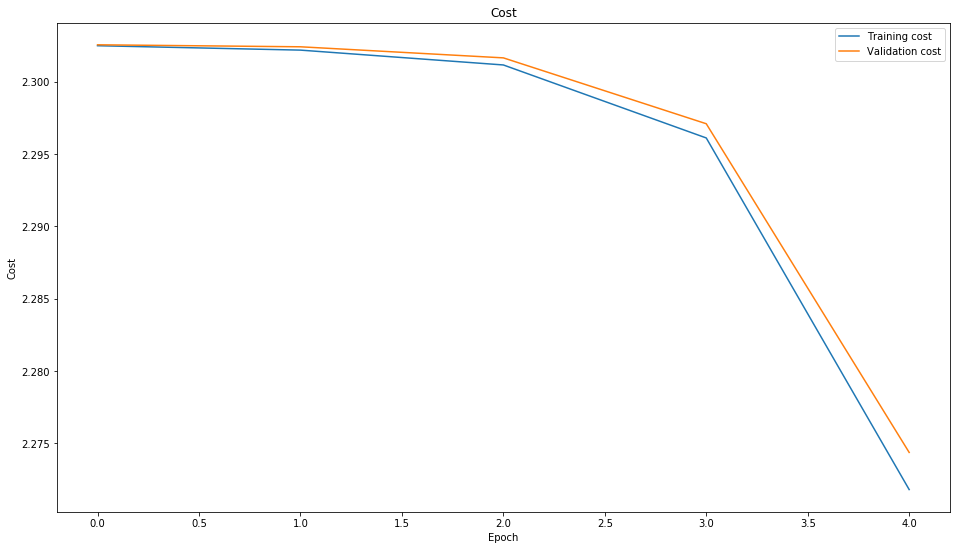

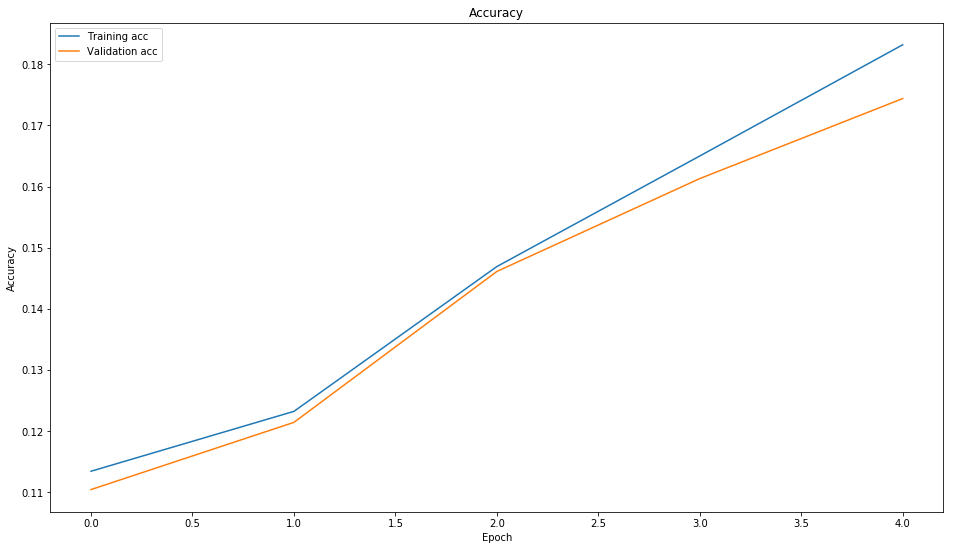

In [795]:
#Exercise 3 - continue seeing the effect of different momentum levels
np.random.seed(5)

inputNodes = 32*32*3 # 32*32*rgb
hiddenNodes = 50
outputNodes = 10

variance = 0.001
    
    
accuracyTraining_Append = []
accuracyValidation_Append = []
costTraining_Append = []
costValidation_Append = []
    
# testing out the effect of proposed momentums
momentumFind = [0.5, 0.9, 0.99] 

for i in range(len(momentumFind)):
    #First layer
    inputWeights = np.random.normal(0.0, variance, (hiddenNodes, inputNodes))
    inputBias = np.random.normal(0.0, variance, (hiddenNodes, 1))

    #Hidden layer
    hiddenWeights = np.random.normal(0.0, variance, (outputNodes, hiddenNodes))
    hiddenBias = np.random.normal(0.0, variance, (outputNodes, 1))

    # Set the parameters here
    eta = 0.005
    epoch = 5
    batch = 500
    lambdaVal = 0.000001
    momentum = momentumFind[i]

    # run the training
    accuracyTraining, accuracyValidation, costTraining, costValidation = train(
        inputWeights, 
        inputBias, 
        hiddenWeights, 
        hiddenBias, 
        training,
        validate, 
        eta, 
        epoch, 
        batch, 
        lambdaVal,
        momentum)
    accuracyTraining_Append.append(accuracyTraining)
    accuracyValidation_Append.append(accuracyValidation)
    costTraining_Append.append(costTraining)
    costValidation_Append.append(costValidation)

    print("Network lambda=" +str(lambdaVal) + " epochs=" + str(epoch) + " batch=" + str(batch) + " eta="+str(eta) + " momentum=" + str(momentum) )
    printInfo(training, validate, testing, inputNodes, inputWeights,inputBias, hiddenWeights, hiddenBias, outputNodes, eta)
    plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


Done
Info on network with lambda=1e-06 epochs=5 batch=100 eta=0.4
Info on Training data: Accuracy: 10.05% and Cost: nan
Info on Validation data: Accuracy: 9.84% and Cost: nan
Info on Testing data: Accuracy: 10.0% and Cost: nan


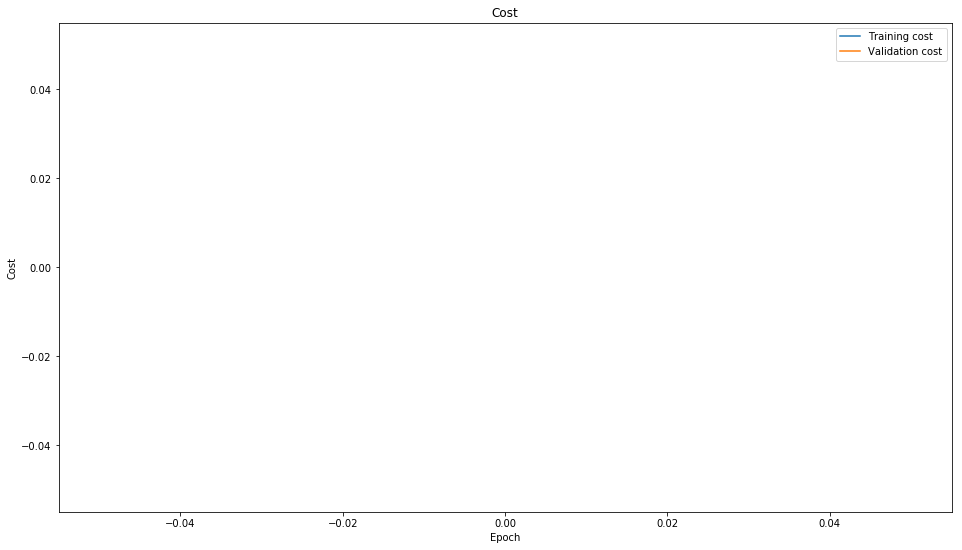

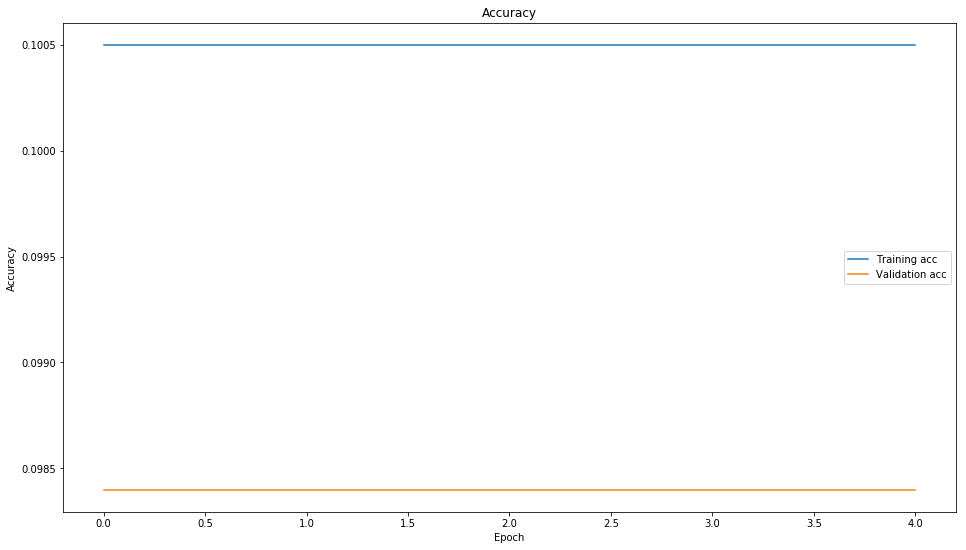

Done
Info on network with lambda=1e-06 epochs=5 batch=100 eta=0.35
Info on Training data: Accuracy: 10.05% and Cost: nan
Info on Validation data: Accuracy: 9.84% and Cost: nan
Info on Testing data: Accuracy: 10.0% and Cost: nan


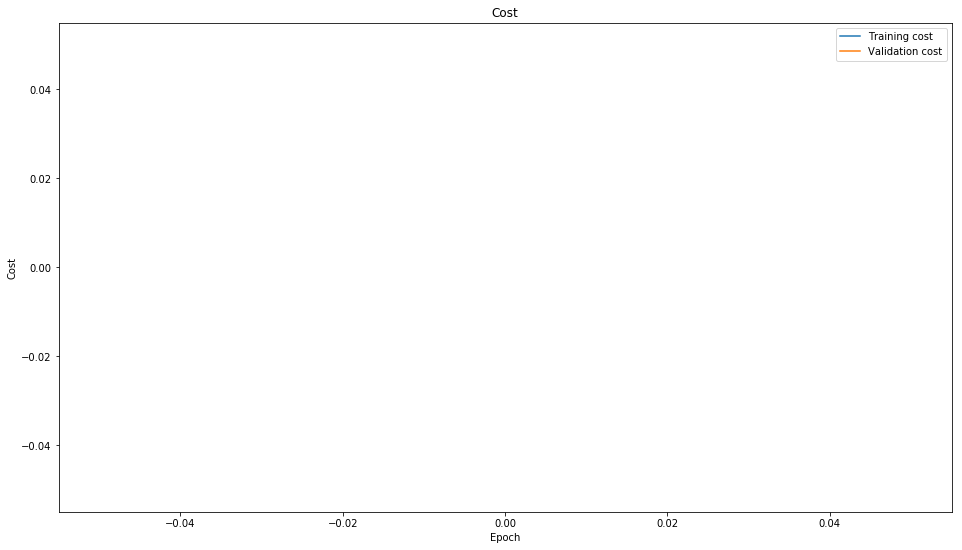

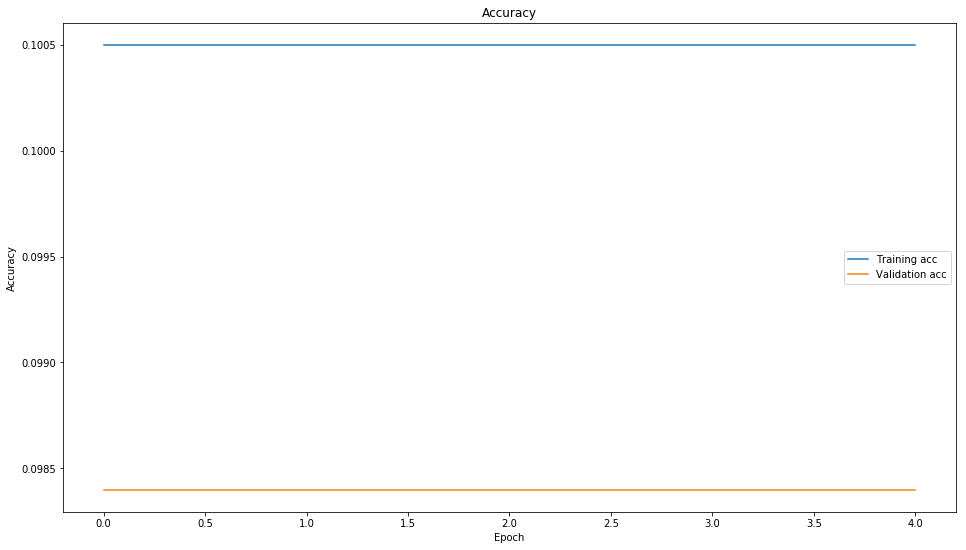

Done
Info on network with lambda=1e-06 epochs=5 batch=100 eta=0.3
Info on Training data: Accuracy: 10.05% and Cost: nan
Info on Validation data: Accuracy: 9.84% and Cost: nan
Info on Testing data: Accuracy: 10.0% and Cost: nan


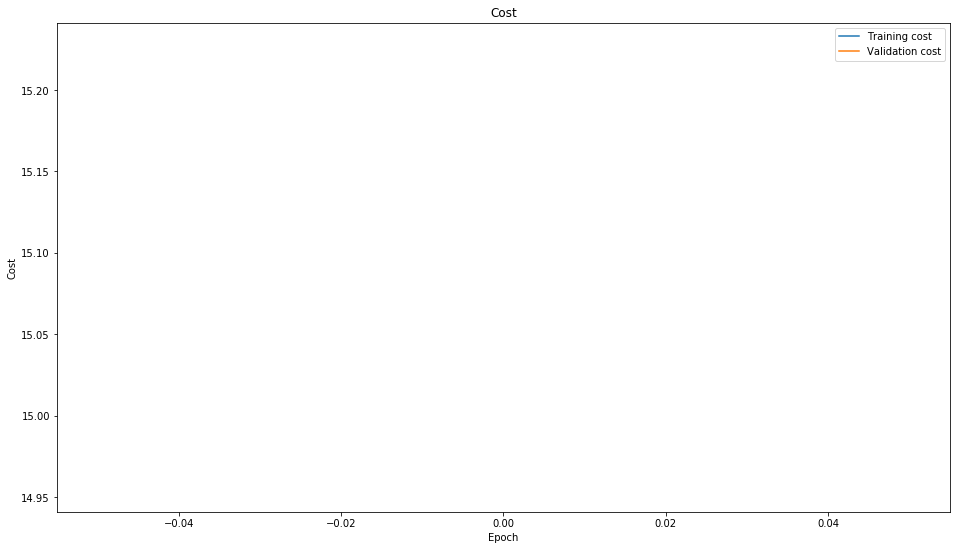

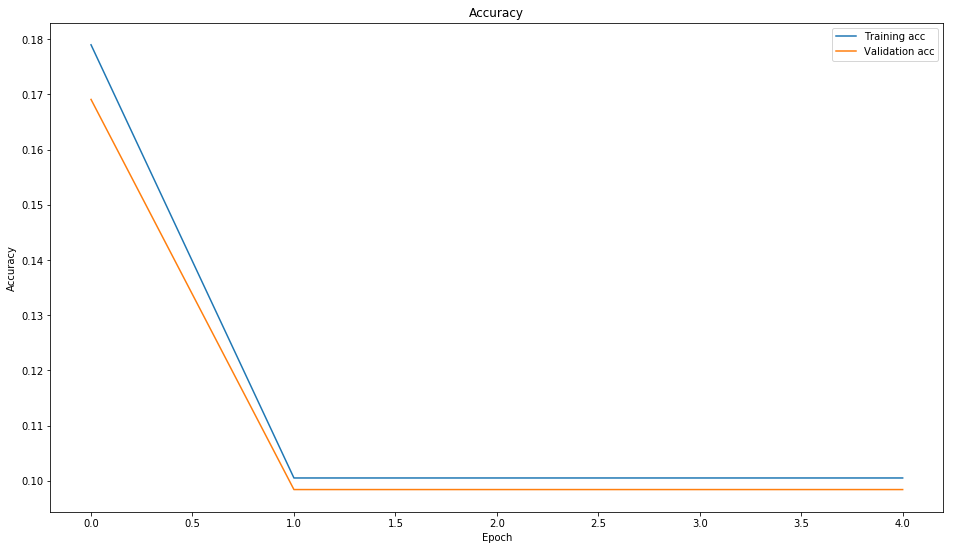

KeyboardInterrupt: 

In [857]:
#Exercise 4 - babysitting time!
# Search for the learning rate. Both course and fine search
import random
np.random.seed(5)

inputNodes = 32*32*3 # 32*32*rgb
hiddenNodes = 50
outputNodes = 10


variance = 0.001
    
    
accuracyTraining_Append = []
accuracyValidation_Append = []
costTraining_Append = []
costValidation_Append = []
    
# Course search for eta
searchLearnRate_course = [0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001] 
# 0.4 - 0.1 was my best

# Fine search for lambda and eta
# Try 80 different pairings
nPairings = 80

# Max and min values for learn rate and optimizer
searchLearnRate_max = 0.4
searchLearnRate_min = 0.1

searchOptimze_max = 0.0001
searchOptimze_min = 0.000001

# Best parameters fine tune
searchLearnRate_max = 0.32
searchLearnRate_min = 0.26

searchOptimze_max = 9.42353e-05
searchOptimze_min = 8.24820e-05


for i in range(len(searchLearnRate_course)):

#for i in range(nPairings):
    #First layer
    inputWeights = np.random.normal(0.0, variance, (hiddenNodes, inputNodes))
    inputBias = np.random.normal(0.0, variance, (hiddenNodes, 1))

    #Hidden layer
    hiddenWeights = np.random.normal(0.0, variance, (outputNodes, hiddenNodes))
    hiddenBias = np.random.normal(0.0, variance, (outputNodes, 1))

    # Set the parameters here
    generateEta = searchLearnRate_min + (searchLearnRate_max - searchLearnRate_min)*random.random()
    generateLamda = searchOptimze_min + (searchOptimze_max - searchOptimze_min)*random.random()
    
    eta = searchLearnRate_fine[i] # For the course search
    #eta = generateEta
    epoch = 5
    batch = 500
    lambdaVal = 0.000001
    #lambdaVal = generateLamda

    momentum = 0.9

    # run the training
    accuracyTraining, accuracyValidation, costTraining, costValidation = train(
        inputWeights, 
        inputBias, 
        hiddenWeights, 
        hiddenBias, 
        training,
        validate, 
        eta, 
        epoch, 
        batch, 
        lambdaVal,
        momentum)
    accuracyTraining_Append.append(accuracyTraining)
    accuracyValidation_Append.append(accuracyValidation)
    costTraining_Append.append(costTraining)
    costValidation_Append.append(costValidation)

    print("Info on network with lambda=" +str(lambdaVal) + " epochs=" + str(epoch) + " batch=" + str(batch) + " eta="+str(eta) )
    printInfo(training, validate, testing, inputNodes, inputWeights,inputBias, hiddenWeights, hiddenBias, outputNodes, eta)
    plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )


In [10]:
# Info functions for report

def printInfo(training, validation, test, inputNodes, weights,bias,h_w,h_b, h2, b2, outputNodes, eta):
   
    probab = evaluateClassifier(np.transpose(training['images']),  weights,bias,h_w,h_b)
    
    
    
    finalAccuracy = computeAccuracy(probab, np.transpose(training['label']))
    finalCost = computeCost(probab, np.transpose(training['label']),  h_w, lambdaVal)
    print("Info on Training data: Accuracy: " + str(round(finalAccuracy*100,2)) + "% and Cost: " + str(round(finalCost,2) ))

    probab = evaluateClassifier(np.transpose(validation['images']),  weights,bias,h_w,h_b)
    val_finalCost = computeCost(probab, np.transpose(validation['label']),  h_w, lambdaVal)
    val_finalAccuracy = computeAccuracy(probab, np.transpose(validation['label']))
    print("Info on Validation data: Accuracy: " + str(round(val_finalAccuracy*100,2)) + "% and Cost: " + str(round(val_finalCost,2) ))

    probab = evaluateClassifier(np.transpose(test['images']),  weights,bias,h_w,h_b)
    test_finalCost = computeCost(probab, np.transpose(test['label']),  h_w, lambdaVal)
    test_finalAccuracy = computeAccuracy(probab, np.transpose(test['label']))
    print("Info on Testing data: Accuracy: " + str(round(test_finalAccuracy*100,2)) + "% and Cost: " + str(round(test_finalCost,2) ))

          
def plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation ):
    plt.plot(costTraining, label='Training cost')
    plt.plot(costValidation, label='Validation cost')
    plt.legend()
    
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Cost')
    plt.show()
    plt.plot(accuracyTraining, label='Training acc')
    plt.plot(accuracyValidation, label='Validation acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.show()

def normalize(weightMatrix):
    maxVal = np.max(weightMatrix)
    minVal = np.min(weightMatrix)
    return (weightMatrix - minVal) / (maxVal - minVal)

def plotweights(W,label):
    for i, row in enumerate(W):
        imgNormalized = normalize(row) # ValueError: Floating point image RGB values must be in the 0..1 range.
        plt.subplot(5, 2, i+1)
        dispImg(imgNormalized, labels[i])
    plt.show()
    
# Run this cell after training to get the information about the trained network
def infoAboutNetwork():
    print("Info on network with lambda=" +str(lambdaVal) + " epochs=" + str(epoch) + " batch=" + str(batch) + " eta="+str(eta) )
    printInfo(training, validate, testing, inputNodes, inputWeights,inputBias, hiddenWeights, hiddenBias, outputNodes, eta)
    plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )
    plotweights(weights, labels)
    


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Done
Info on network with lambda=8.248206928786062e-05 epochs=30 batch=500 eta=0.29189273799480775
Info on Training data: Accuracy: 63.27% and Cost: 1.04
Info on Validation data: Accuracy: 48.0% and Cost: 1.56
Info on Testing data: Accuracy: 48.34% and Cost: 1.58


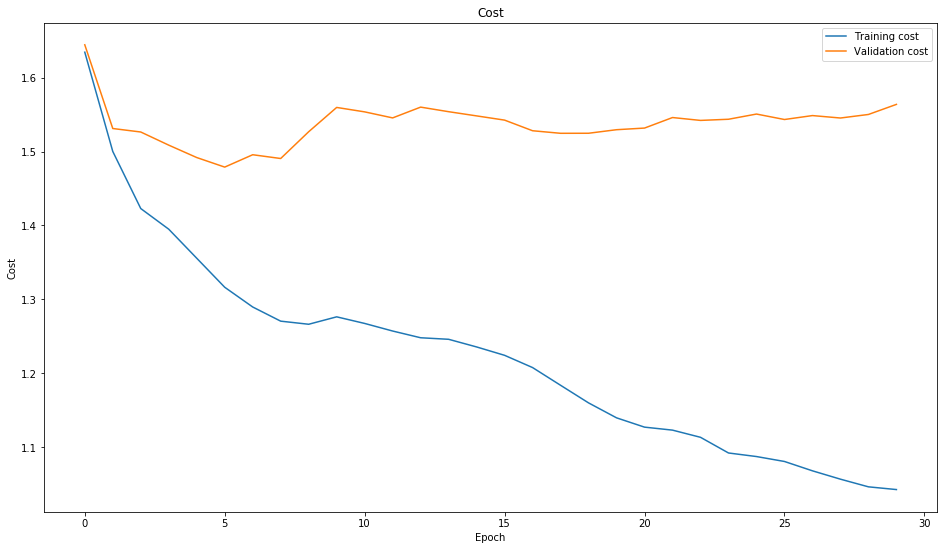

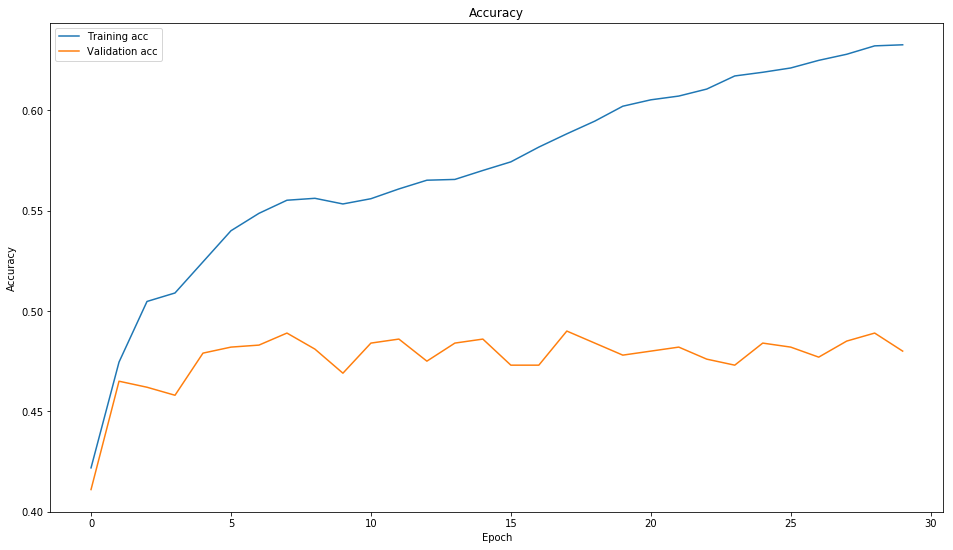

In [872]:

# BEST NETWORK

import random
np.random.seed(5)

inputNodes = 32*32*3 # 32*32*rgb
hiddenNodes = 50
outputNodes = 10

variance = 0.001
    
#First layer
inputWeights = np.random.normal(0.0, variance, (hiddenNodes, inputNodes))
inputBias = np.random.normal(0.0, variance, (hiddenNodes, 1))

#Hidden layer
hiddenWeights = np.random.normal(0.0, variance, (outputNodes, hiddenNodes))
hiddenBias = np.random.normal(0.0, variance, (outputNodes, 1))

eta = 0.29189273799480775
epoch = 30
batch = 500
lambdaVal = 8.248206928786062e-05
momentum = 0.9


# run the training
accuracyTraining, accuracyValidation, costTraining, costValidation = train(
    inputWeights, 
    inputBias, 
    hiddenWeights, 
    hiddenBias, 
    training,
    validate, 
    eta, 
    epoch, 
    batch, 
    lambdaVal,
    momentum)

print("Info on network with lambda=" +str(lambdaVal) + " epochs=" + str(epoch) + " batch=" + str(batch) + " eta="+str(eta) )
printInfo(training, validate_1000, testing, inputNodes, inputWeights,inputBias, hiddenWeights, hiddenBias, outputNodes, eta)
plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )
